In [14]:
import numpy as np
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot

# 1. Twitch API data

The URL `https://wind-bow.glitch.me/twitch-api/channels/{CHANNEL_NAME}` is an API from twitch to get data from twitch channels.

Get the data from the following channels:

```
["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]
```

To make into a dataframe that looks like this:

![](twitch.png)

In [3]:
import requests 

channels = ["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",  "ninja", 
    "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]

# keys = ['_id','display_name','status','followers','views']

channels_list = []

for display_name in channels:
    r = json.loads(requests.get('https://wind-bow.glitch.me/twitch-api/channels/' + display_name).content)
    if 'error' not in r:
        channels_list.append([r['_id'], r['name'], r['status'], r['followers'], r['views']])
    # print(display_name, r)
# print(channels_list)

In [4]:
df = pd.DataFrame.from_dict(channels_list)
df.columns = ['id', 'display_name', 'status', 'followers', 'views']
df

,id,display_name,status,followers,views
0,30220059,esl_sc2,RERUN: StarCraft 2 - Terminator vs. Parting (P...,135394,60991791
1,71852806,ogamingsc2,UnderDogs - Rediffusion - Qualifier.,40895,20694507
2,90401618,cretetion,It's a Divison kind of Day,908,11631
3,79776140,freecodecamp,Greg working on Electron-Vue boilerplate w/ Ak...,10122,163747
4,86238744,storbeck,None,10,1019
5,6726509,habathcx,Massively Effective,14,764
6,54925078,robotcaleb,Code wrangling,20,4602
7,82534701,noobs2ninjas,Building a new hackintosh for #programming and...,835,48102


In [11]:
# how to see json content in a more presentable way
JSONContent = requests.get('https://wind-bow.glitch.me/twitch-api/channels/ESL_SC2').json()
content = json.dumps(JSONContent, indent = 4, sort_keys=True)
# print(content)

# 2. App Store Reviews

The Apple app store has a `GET` API to get reviews on apps. The URL is:

```
https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json
```

Note that you need to provide:

- The country code (eg. `'us'`, `'gb'`, `'ca'`, `'au'`) 

- The app ID. This can be found in the web page for the app right after `id`. For instance, Candy Crush's US webpage is:

`https://apps.apple.com/us/app/candy-crush-saga/id553834731`

So here the ID would be `553834731`.

- The "Page Number". The request responds with multiple pages of data, but sends them one at a time. So you can cycle through the data pages for any app on any country.

### 2.1 English app reviews

Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

### 2.2 Best version

For each app, get the version that is the best rated.

Make a visualization of the ratings per versions per app to show this.

### 2.3 Top words

Which word for each app is most common in the 5 star and in the 1-star review's titles?

Note: `df.title.str.get_dummies()` is your friend

Note: This might create a lot of data! Try to break down your analysis in chunks if it doesn't work.

In [ ]:
# 2.1 Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

In [6]:
df = pd.DataFrame(columns = ['countries', 'app', 'review', 'title', 'version', 'rating'])
empty_df = df.copy()

In [7]:
COUNTRY_CODE = ['us','gb','ca','au']
APP_ID = {'Candy Crush': '553834731','Tinder': '547702041','Facebook': '284882215','Twitter': '333903271'}
PAGE_NUMBER = [str(i) for i in range(1,99)] #running through all pages until no more pages
REVIEW_LIST = []
#df = pd.DataFrame(columns = keys)
# try:
for app, id_n in APP_ID.items():
    for country in COUNTRY_CODE:
        for page in PAGE_NUMBER:
            r = requests.get(f'https://itunes.apple.com/{country}/rss/customerreviews/id={id_n}/page={page}/sortby=mostrecent/json')
            if r: # will exit this forloop if page number doesnt exist
                cont = json.loads(r.content)
                c = cont['feed']['entry']
                temp_df = empty_df.copy()
                for i in range(0,len(c)):
                    temp_df = pd.concat(
                        [temp_df, pd.DataFrame(
                            data={'countries' : [country], 
                                  'app' : [app], 'review' : [c[i]['content']['label']], 'title' : [c[i]['title']['label']], 'version' : [c[i]['im:version']['label']], 'rating' : [c[i]['im:rating']['label']]})])
                df = df.append(temp_df, ignore_index=True)
            else:
                break;

In [8]:
# 2.1 Reviews from English countries

df[['countries', 'app', 'review']]

,countries,app,review
0,us,Candy Crush,This app seems to have flooded the internet wi...
1,us,Candy Crush,"Since last update, it just sits on the “loadin..."
2,us,Candy Crush,"For the last 3 or 4 days, the app will only lo..."
3,us,Candy Crush,I don’t know why I can’t retrieve my progress ...
4,us,Candy Crush,Please extend the playtime. \n\nThank you!
...,...,...,...
7995,au,Twitter,The censorship has become so one sided its bor...
7996,au,Twitter,Still have no idea why I was taken off perisco...
7997,au,Twitter,Good app but to avoid advert pollution. Go els...
7998,au,Twitter,"Take away the Political bias Twitter, you have..."


In [10]:
# 2.2 For each app, version that is best rated

df.rating = df.rating.astype(int)

In [92]:
# df1 = df.groupby(['app','version'])['rating'].mean().reset_index().sort_values(by='rating', ascending='False')
df1 = df.groupby(['app','version'])['rating'].mean().sort_values(ascending=False)


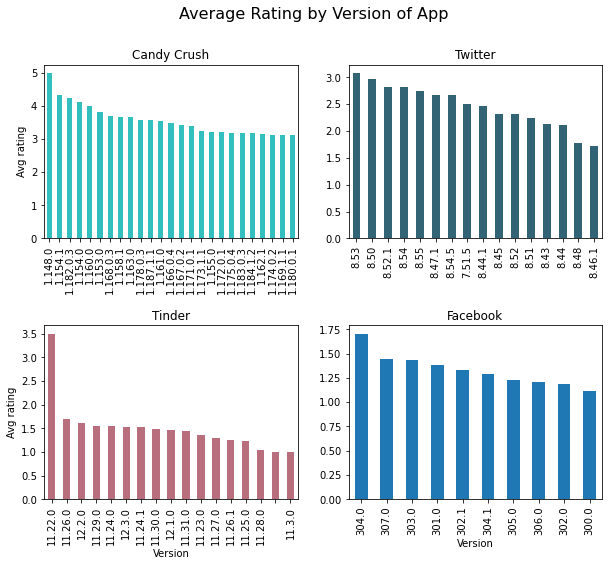

In [96]:
# Sorted best to worst rated
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# fig.tight_layout(pad=4.0)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
df1['Candy Crush'][:25].plot.bar(ax=axes[0,0], color=(0, 0.69, 0.69, 0.8))
axes[0,0].set_title('Candy Crush')
axes[0,0].set_ylabel("Avg rating")
axes[0,0].xaxis.label.set_visible(False)
df1['Twitter'][:25].plot.bar(ax=axes[0,1], color=(0, 0.24, 0.32, 0.8))
axes[0,1].set_title('Twitter')
axes[0,1].xaxis.label.set_visible(False)
df1['Tinder'][:25].plot.bar(ax=axes[1,0], color=(0.66, 0.29, 0.36, 0.8))
axes[1,0].set_title('Tinder')
axes[1,0].set_ylabel("Avg rating")
axes[1,0].set_xlabel("Version")
df1['Facebook'][:25].plot.bar(ax=axes[1,1])
axes[1,1].set_title('Facebook')
axes[1,1].set_xlabel("Version")
plt.suptitle('Average Rating by Version of App', size=16);

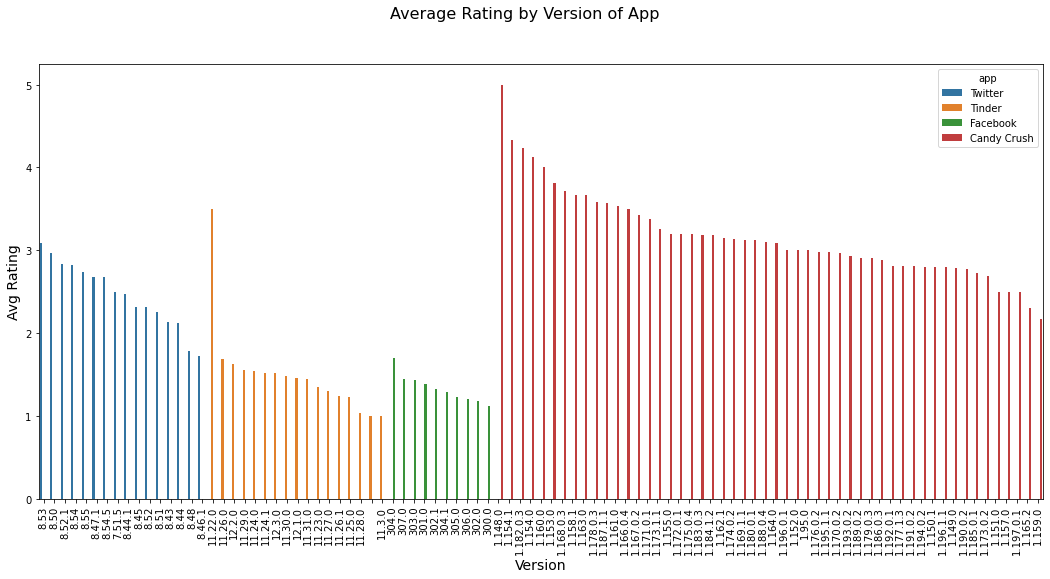

In [105]:
# Or this way:

import seaborn as sns
import matplotlib.pyplot as plt 


df_sorted = df.groupby(['app', 'version'])['rating'].mean().reset_index().sort_values(by=['app', 'rating'], ascending=False)
x = df.groupby(['app', 'version'])
plt, ax = plt.subplots(figsize = (18,8))

plot=sns.barplot(x = 'version', y='rating', data=df_sorted, hue='app')
# plt.setp(plot.get_xticklabels(), rotation=90)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set_xlabel("Version",fontsize=14)
plot.set_ylabel("Avg Rating",fontsize=14)
plt.suptitle('Average Rating by Version of App', size=16);
# sns.histplot(data=df_rating, x='version', y='rating')


In [50]:
# To see api content better 
g = requests.get('https://itunes.apple.com/ca/rss/customerreviews/id=553834731/page=1/sortby=mostrecent/json')
JSONContent = g.json()
content = json.dumps(JSONContent, indent = 4, sort_keys=True)
# print(content[:1200])

In [ ]:
# 2.3 Which word for each app is most common in the 5 star and in the 1-star review's titles?

In [388]:
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_word = df[['app','title', 'rating']]

df_word['title'] = df_word['title'].str.lower().str.extract('([aA-zZ][\w\s]+)') #transforms to lower case and only keeps letters
df_word['title'] = df_word['title'].str.split(" ")
df_word = df_word.dropna()
df_word['title'] = df_word['title'].apply(lambda x: [item for item in x if item not in stop]) #gets rid of stopwords 


rate={"Candy Crush": [], "Twitter": [], "Tinder": [], "Facebook": []}
RATING = [1, 5]
for r in RATING:
    for app in APP_ID:
        df_app = df_word[df_word['app'] == app]
        # df_word_1 = df_app[df_app.rating == r]
        df_word_1 = df_app.loc[df_app['rating'] == r]
        myx = (df_word_1['title'].str.get_dummies(sep=' ')
                                 .drop('[]', axis=1)
                                 .sum(axis=0)
                                 .idxmax())
        rate[app].append(myx)



In [389]:
for app in APP_ID: 
    print(f"{app}'s most common 5 star rating word: {rate[app][0]}")
    print(f"{app}'s most common 1 star rating: {rate[app][1]}\n")

Candy Crush's most common 5 star rating word: ['candy',
Candy Crush's most common 1 star rating: ['candy',

Tinder's most common 5 star rating word: 'reason']
Tinder's most common 1 star rating: 'app']

Facebook's most common 5 star rating word: ['facebook',
Facebook's most common 1 star rating: ['facebook',

Twitter's most common 5 star rating word: ['censorship']
Twitter's most common 1 star rating: ['twitter',



# 3 (STRETCH) IMDB scraping

IMDB has structured web pages. We can exploit this to scrape movie data.

Usinf the following URL:

`https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt`

With the following headers in your `GET` request: `{"Accept-Language": "en-US,en;q=0.5"}`

You can generate a dataframe like this one by cycling over the page numbers in the URL requested:

![](IMDB.png)

Note that the following  page attribues will be of interest:

- `div` with a class of `lister-item mode-advanced`

- Various `span` objects within that `div` like `lister-item-year` and `runtime` and `metascore`

In [ ]:
# not done the stretch goal :(

In [391]:
from bs4 import BeautifulSoup
titles = []
year = []
imdb = []
metascore = []
votes = []
us_grossMillions = []
timeMin = []


PAGE_NUMBER = range(1,1001, 50)
for page in PAGE_NUMBER:
    r_3 = requests.get(f'https://www.imdb.com/search/title/?groups=top_1000&start={page}&ref_=adv_nxt', {"Accept-Language": "en-US,en;q=0.5"})
# {"Accept-Language": "en-US,en;q=0.5"}
# r_3.content
# m = requests.get('https://itunes.apple.com/' + country + '/rss/customerreviews/id=' + app +'/page=' + page +'/sortby=mostrecent/json')
soup = BeautifulSoup(r_3.content, 'html.parser')
soup.prettify()
content = soup.find('div', {'class':"lister-item mode-advanced"})

movie_div = soup.find_all('div', class_='lister-item mode-advanced')

for container in movie_div:
    # Scraping the movie's name
    name = container.h3.a.text
    titles.append(name)



In [392]:
movie_div = soup.find_all('div', class_='lister-item mode-advanced')

for container in movie_div:
    # Scraping the movie's name
    name = container.h3.a.text
    titles.append(name)

In [393]:
# titles

In [394]:
soup = BeautifulSoup(r_3.content, 'html.parser')
table = soup.find_all(class_='lister-item mode-advanced')
table = soup.find_all(class_='lister-item-year')
table = soup.find_all('h3', {'class':"lister-item-header"})
# table

In [368]:
article = ''
for i in content.findAll('p'):
    article = article + ' ' +  i.text
